In [1]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#Importing libraries
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split



In [3]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive


Mounted at /content/drive


In [4]:

# Install Kaggle and unzip dataset
!pip install -q kaggle

# Upload your kaggle.json API token file (get it from https://www.kaggle.com/account)
from google.colab import files
files.upload()  # upload kaggle.json

# Create kaggle directory and move token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle (replace with actual dataset name)
!kaggle datasets download -d murtozalikhon/brain-tumor-multimodal-image-ct-and-mri

# Unzip dataset
!unzip -q brain-tumor-multimodal-image-ct-and-mri.zip -d ./brain_tumor_data


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
License(s): CC-BY-NC-SA-4.0


In [5]:
#Device agnostic code
if torch.cuda.is_available():
    device = "cuda"
    print('cuda')
else:
    device = "cpu"
    print('cpu')


cuda


In [6]:
def get_data_loaders():
    transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a larger size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

    #Creating Dataloaders for Magnetic Resonance Imaging
    MRI = datasets.ImageFolder(root='./brain_tumor_data/Dataset/Brain Tumor MRI images', transform=transform)

    MRI_dataloader = DataLoader(MRI, batch_size=32, shuffle=True)
    MRI_train_size = int(0.8 * len(MRI))
    MRI_test_size = len(MRI) - MRI_train_size

    MRI_train_dataset, MRI_test_dataset = random_split(MRI, [MRI_train_size, MRI_test_size])

    MRI_train_loader = DataLoader(MRI_train_dataset, batch_size=32, shuffle=True)
    MRI_test_loader = DataLoader(MRI_test_dataset, batch_size=32, shuffle=True)

    print("MRI Training set size:", len(MRI_train_dataset))
    print("MRI Testing set size:", len(MRI_test_dataset))

    return MRI,MRI_train_dataset,MRI_test_dataset,MRI_train_loader,MRI_test_loader

MRI,MRI_train_dataset,MRI_test_dataset,MRI_train_loader,MRI_test_loader=get_data_loaders()


MRI Training set size: 4000
MRI Testing set size: 1000


In [7]:
print(MRI_train_dataset.dataset.class_to_idx)


{'Healthy': 0, 'Tumor': 1}


In [8]:
# Dataset path from Kaggle
base_path = "./brain_tumor_data/Dataset/Brain Tumor MRI images"
categories = ["Healthy", "Tumor"]

image_paths, labels = [], []
for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_paths.append(os.path.join(category_path, image_name))
        labels.append(category)

df = pd.DataFrame({"image_path": image_paths, "label": labels})
df.head()


image_path    label
0  ./brain_tumor_data/Dataset/Brain Tumor MRI ima...  Healthy
1  ./brain_tumor_data/Dataset/Brain Tumor MRI ima...  Healthy
2  ./brain_tumor_data/Dataset/Brain Tumor MRI ima...  Healthy
3  ./brain_tumor_data/Dataset/Brain Tumor MRI ima...  Healthy
4  ./brain_tumor_data/Dataset/Brain Tumor MRI ima...  Healthy

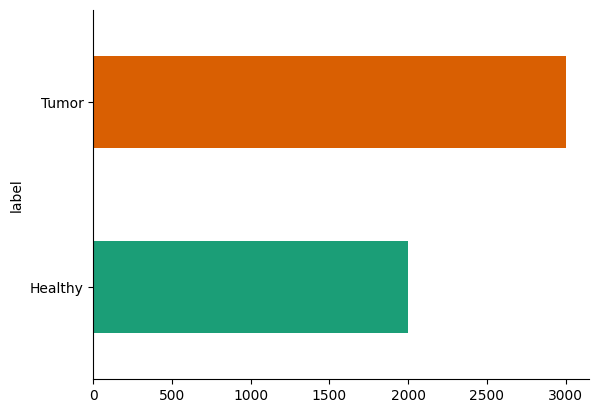

In [9]:

from matplotlib import pyplot as plt

df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

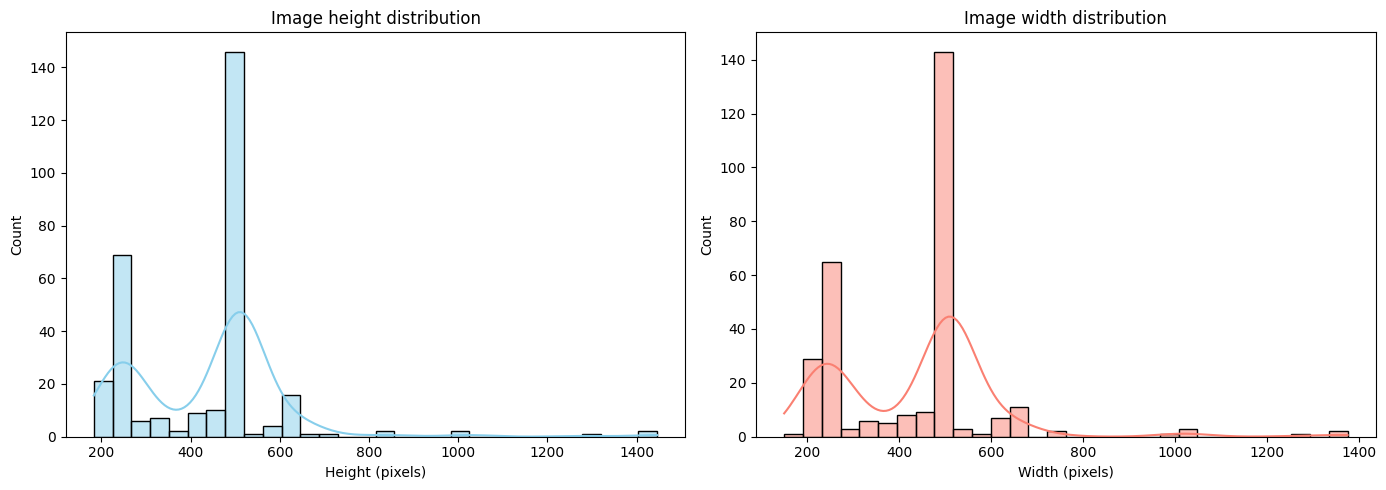

In [10]:

# Compute image sizes and distribution
image_heights = []
image_widths = []

for path in df['image_path'].sample(300):  # Use sample to speed up visualization
    try:
        img = cv2.imread(path)
        h, w = img.shape[:2]
        image_heights.append(h)
        image_widths.append(w)
    except:
        continue  # In case any image is unreadable

# Plot height and width distributions
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(image_heights, bins=30, kde=True, color='skyblue')
plt.title("Image height distribution")
plt.xlabel("Height (pixels)")

plt.subplot(1, 2, 2)
sns.histplot(image_widths, bins=30, kde=True, color='salmon')
plt.title("Image width distribution")
plt.xlabel("Width (pixels)")

plt.tight_layout()
plt.show()


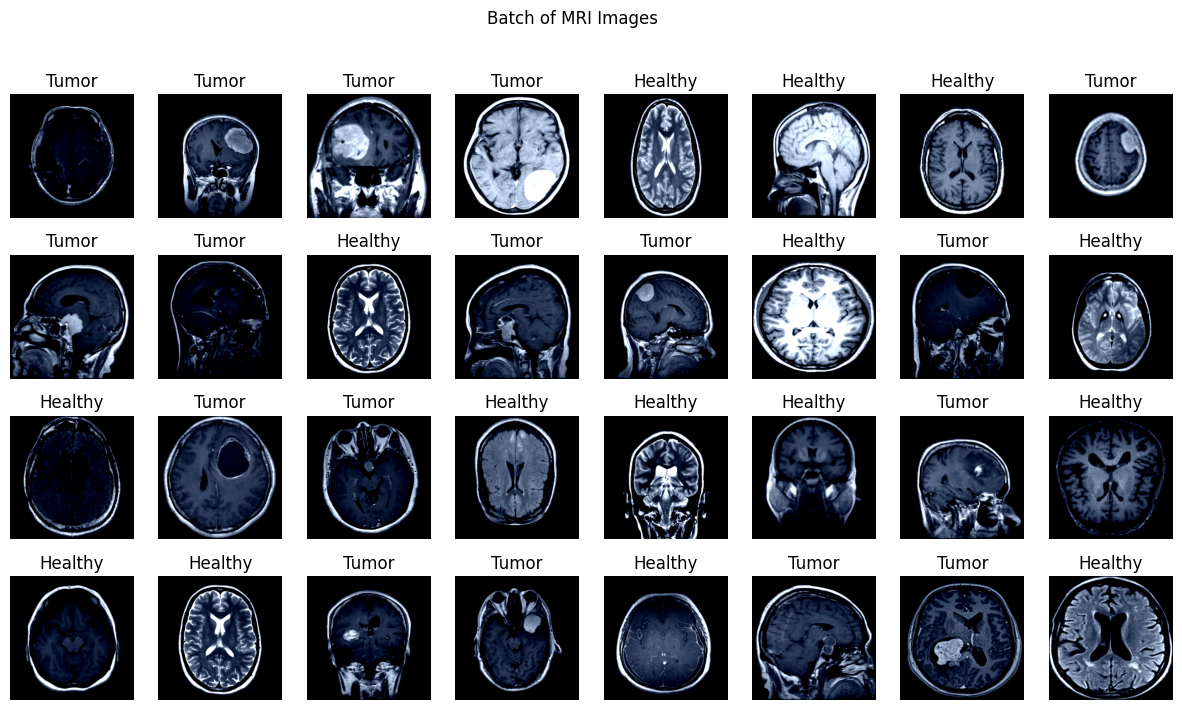

In [11]:
#Display some batches of MRI images

def show_MRI_batch(dataloader, title="Batch of MRI Images"):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    fig.suptitle(title)

    # Assuming these are the normalization parameters you used
    mean = torch.tensor([0.5, 0.5, 0.5])  # example values
    std = torch.tensor([0.5, 0.5, 0.5])   # example values

    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            img = images[i].permute(1, 2, 0)  # Convert tensor image for plotting

            # Undo normalization
            img = img * std + mean

            # Clip to valid range just in case
            img = torch.clamp(img, 0, 1)

            ax.imshow(img)
            ax.set_title(MRI.classes[labels[i]])
            ax.axis('off')
    plt.show()
show_MRI_batch(MRI_train_loader)

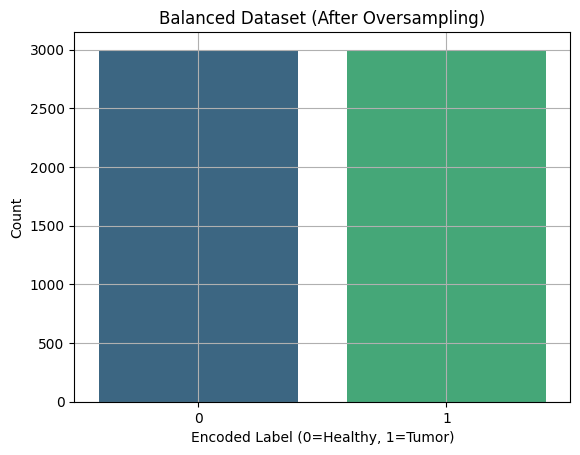

In [12]:

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Encode text labels ("Healthy", "Tumor") to integers
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])  # Healthy = 0, Tumor = 1

# Balance dataset using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df[["image_path"]], df["label_encoded"])

# Create new balanced DataFrame
df_res = pd.DataFrame(X_res, columns=["image_path"])
df_res["label_encoded"] = y_res

# Check new distribution
sns.countplot(data=df_res, x="label_encoded", palette="viridis")
plt.title("Balanced Dataset (After Oversampling)")
plt.xlabel("Encoded Label (0=Healthy, 1=Tumor)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [13]:
from sklearn.model_selection import train_test_split

# Split into train (80%) and temp (20%)
train_df, temp_df = train_test_split(
    df_res,
    train_size=0.8,
    stratify=df_res["label_encoded"],
    random_state=42
)

# Split temp into validation (10%) and test (10%)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label_encoded"],
    random_state=42
)

# Print how many samples in each set
print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(valid_df)} images")
print(f"Test set: {len(test_df)} images")


Training set: 4800 images
Validation set: 600 images
Test set: 600 images


In [14]:
# Define a CNN model for MRI image classification

import torch.nn as nn

class MRIModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.layer_stack = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second convolutional layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third convolutional layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fourth convolutional layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fifth convolutional layer
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Sixth convolutional layer
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Adding AdaptiveAvgPool2d to reduce the spatial dimension effectively
            nn.AdaptiveAvgPool2d(1),

            # Final layer to output the class predictions
            nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.layer_stack(x)
        # Flatten the output to match the size (batch_size, num_classes)
        return x.view(x.size(0), -1)

# Instantiate the model
mri_model = MRIModel(in_channels=3, num_classes=2)  # Assuming RGB input (3 channels)
print(mri_model)


MRIModel(
  (layer_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [15]:
# Define the loss function and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(mri_model.parameters(),lr=0.001)
mri_model=mri_model.to(device)

In [16]:
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report

num_epochs = 20

# Storage for plotting and evaluation
train_losses = []
val_losses = []
val_accuracies = []
f1_scores = []

# To gather predictions and true labels for classification report
mri_all_labels = []
mri_all_predictions = []

for epoch in range(num_epochs):
    mri_model.train()
    running_loss = 0.0

    for images, labels in tqdm(MRI_train_loader, desc=f"Training Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mri_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(MRI_train_loader)
    train_losses.append(train_loss)

    # Validation
    mri_model.eval()
    correct = 0
    total = 0
    val_running_loss = 0.0

    # Reset predictions and labels for this epoch
    epoch_labels = []
    epoch_predictions = []

    with torch.inference_mode():
        for images, labels in tqdm(MRI_test_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = mri_model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            epoch_labels.extend(labels.cpu().numpy())
            epoch_predictions.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Store metrics
    val_accuracy = 100 * correct / total
    val_loss = val_running_loss / len(MRI_test_loader)
    epoch_f1 = f1_score(epoch_labels, epoch_predictions, average='weighted')

    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    f1_scores.append(epoch_f1)

    # Append all predictions for full classification report
    mri_all_labels.extend(epoch_labels)
    mri_all_predictions.extend(epoch_predictions)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_accuracy:.2f}%, "
          f"F1 Score: {epoch_f1:.4f}")


Validating: 100%|██████████| 32/32 [00:05<00:00,  5.52it/s]


Epoch [1/20], Train Loss: 0.6513, Val Loss: 0.5065, Val Acc: 79.10%, F1 Score: 0.7875


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch [2/20], Train Loss: 0.4849, Val Loss: 0.4028, Val Acc: 81.90%, F1 Score: 0.8166


Validating: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s]


Epoch [3/20], Train Loss: 0.3827, Val Loss: 0.3267, Val Acc: 86.10%, F1 Score: 0.8607


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.49it/s]


Epoch [4/20], Train Loss: 0.3125, Val Loss: 0.3310, Val Acc: 85.60%, F1 Score: 0.8543


Validating: 100%|██████████| 32/32 [00:05<00:00,  5.39it/s]


Epoch [5/20], Train Loss: 0.2775, Val Loss: 0.2403, Val Acc: 89.10%, F1 Score: 0.8900


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch [6/20], Train Loss: 0.2174, Val Loss: 0.1717, Val Acc: 92.50%, F1 Score: 0.9250


Validating: 100%|██████████| 32/32 [00:05<00:00,  5.51it/s]


Epoch [7/20], Train Loss: 0.1873, Val Loss: 0.1867, Val Acc: 92.50%, F1 Score: 0.9254


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Epoch [8/20], Train Loss: 0.1660, Val Loss: 0.1666, Val Acc: 92.70%, F1 Score: 0.9262


Validating: 100%|██████████| 32/32 [00:05<00:00,  5.40it/s]


Epoch [9/20], Train Loss: 0.1268, Val Loss: 0.1578, Val Acc: 93.80%, F1 Score: 0.9371


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.58it/s]


Epoch [10/20], Train Loss: 0.1053, Val Loss: 0.1273, Val Acc: 95.10%, F1 Score: 0.9506


Validating: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


Epoch [11/20], Train Loss: 0.0687, Val Loss: 0.1077, Val Acc: 96.20%, F1 Score: 0.9621


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s]


Epoch [12/20], Train Loss: 0.0482, Val Loss: 0.1082, Val Acc: 96.10%, F1 Score: 0.9612


Validating: 100%|██████████| 32/32 [00:05<00:00,  6.13it/s]


Epoch [13/20], Train Loss: 0.0399, Val Loss: 0.0992, Val Acc: 97.00%, F1 Score: 0.9702


Validating: 100%|██████████| 32/32 [00:05<00:00,  6.20it/s]


Epoch [14/20], Train Loss: 0.0322, Val Loss: 0.0716, Val Acc: 97.70%, F1 Score: 0.9771


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.46it/s]


Epoch [15/20], Train Loss: 0.0194, Val Loss: 0.1606, Val Acc: 96.30%, F1 Score: 0.9632


Validating: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


Epoch [16/20], Train Loss: 0.0380, Val Loss: 0.0998, Val Acc: 96.40%, F1 Score: 0.9640


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]


Epoch [17/20], Train Loss: 0.0086, Val Loss: 0.0782, Val Acc: 98.30%, F1 Score: 0.9830


Validating: 100%|██████████| 32/32 [00:05<00:00,  5.56it/s]


Epoch [18/20], Train Loss: 0.0075, Val Loss: 0.0887, Val Acc: 97.80%, F1 Score: 0.9780


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.40it/s]


Epoch [19/20], Train Loss: 0.0018, Val Loss: 0.0895, Val Acc: 97.50%, F1 Score: 0.9750


Validating: 100%|██████████| 32/32 [00:05<00:00,  5.37it/s]


Epoch [20/20], Train Loss: 0.0454, Val Loss: 0.0539, Val Acc: 98.60%, F1 Score: 0.9860


In [17]:
# Path to your colabbooks folder in Drive
save_path = "/content/drive/MyDrive/Colab Notebooks/mri_model.pth"

# Save the model
torch.save(mri_model.state_dict(), save_path)

print(f"Model saved to: {save_path}")


Model saved to: /content/drive/MyDrive/Colab Notebooks/mri_model.pth


In [ ]:
# Print summary of model history
print(f"Minimum Training Loss: {min(train_losses):.4f}")
print(f"Minimum Validation Loss: {min(val_losses):.4f}")
print(f"Maximum Validation Accuracy: {max(val_accuracies):.2f}%")
print(f"Maximum F1 Score: {max(f1_scores):.4f}")



Final Weighted F1-score on validation set: 0.9300

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.92      0.90      0.91      7860
       Tumor       0.94      0.95      0.94     12140

    accuracy                           0.93     20000
   macro avg       0.93      0.92      0.93     20000
weighted avg       0.93      0.93      0.93     20000

Training metrics plot saved to: /content/drive/MyDrive/Colab Notebooks/training_metrics.png


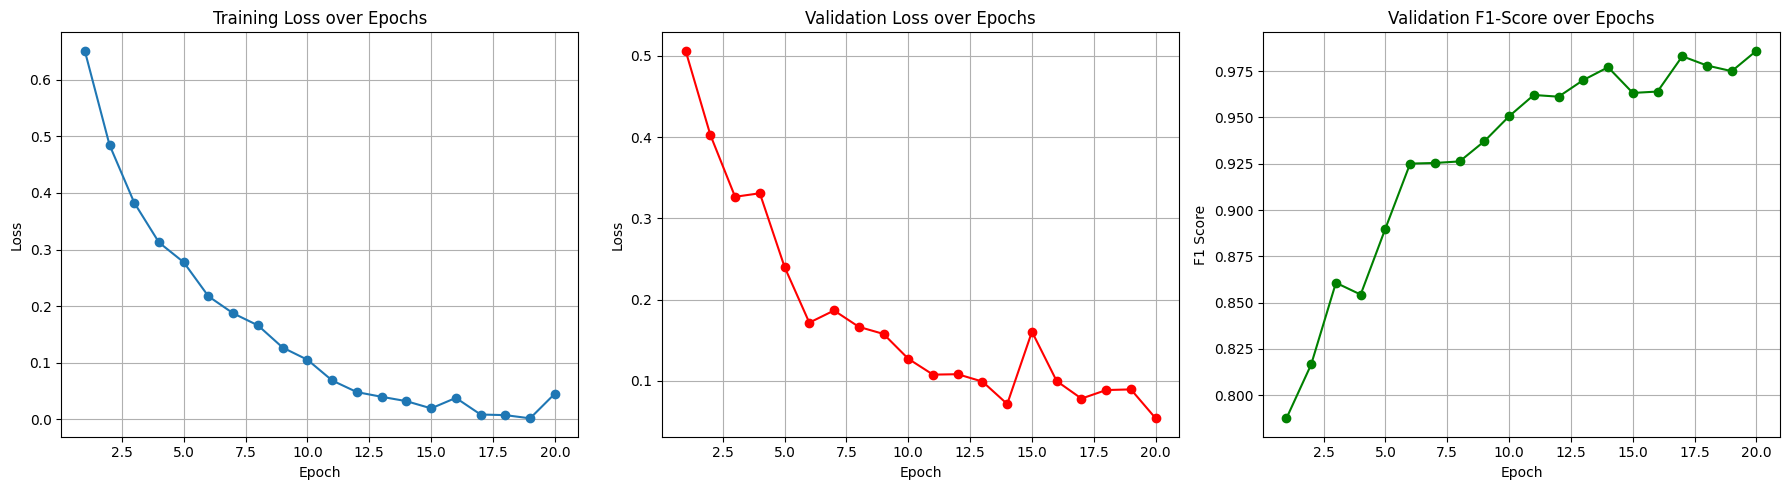

In [18]:

# ---- Evaluation after training ----

# Final classification report
final_f1 = f1_score(mri_all_labels, mri_all_predictions, average='weighted')
report = classification_report(mri_all_labels, mri_all_predictions, target_names=["Healthy", "Tumor"])

print(f"\nFinal Weighted F1-score on validation set: {final_f1:.4f}")
print("\nClassification Report:\n", report)

# ---- Plot metrics ----

plt.figure(figsize=(18, 5))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Validation Loss
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', color='red')
plt.title("Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# F1 Score
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), f1_scores, marker='o', color='green')
plt.title("Validation F1-Score over Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)

plt.tight_layout()

# Save to Drive
metrics_plot_path = "/content/drive/MyDrive/Colab Notebooks/training_metrics.png"
plt.savefig(metrics_plot_path, bbox_inches='tight')
print(f"Training metrics plot saved to: {metrics_plot_path}")
plt.show()


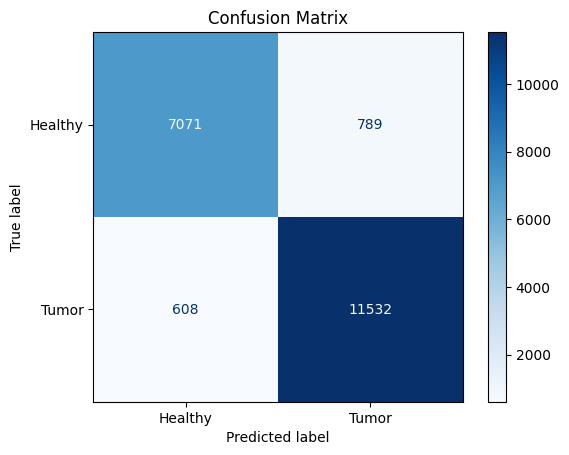

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(mri_all_labels, mri_all_predictions)
class_names = ['Healthy', 'Tumor']  # Replace with your actual class labels

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()


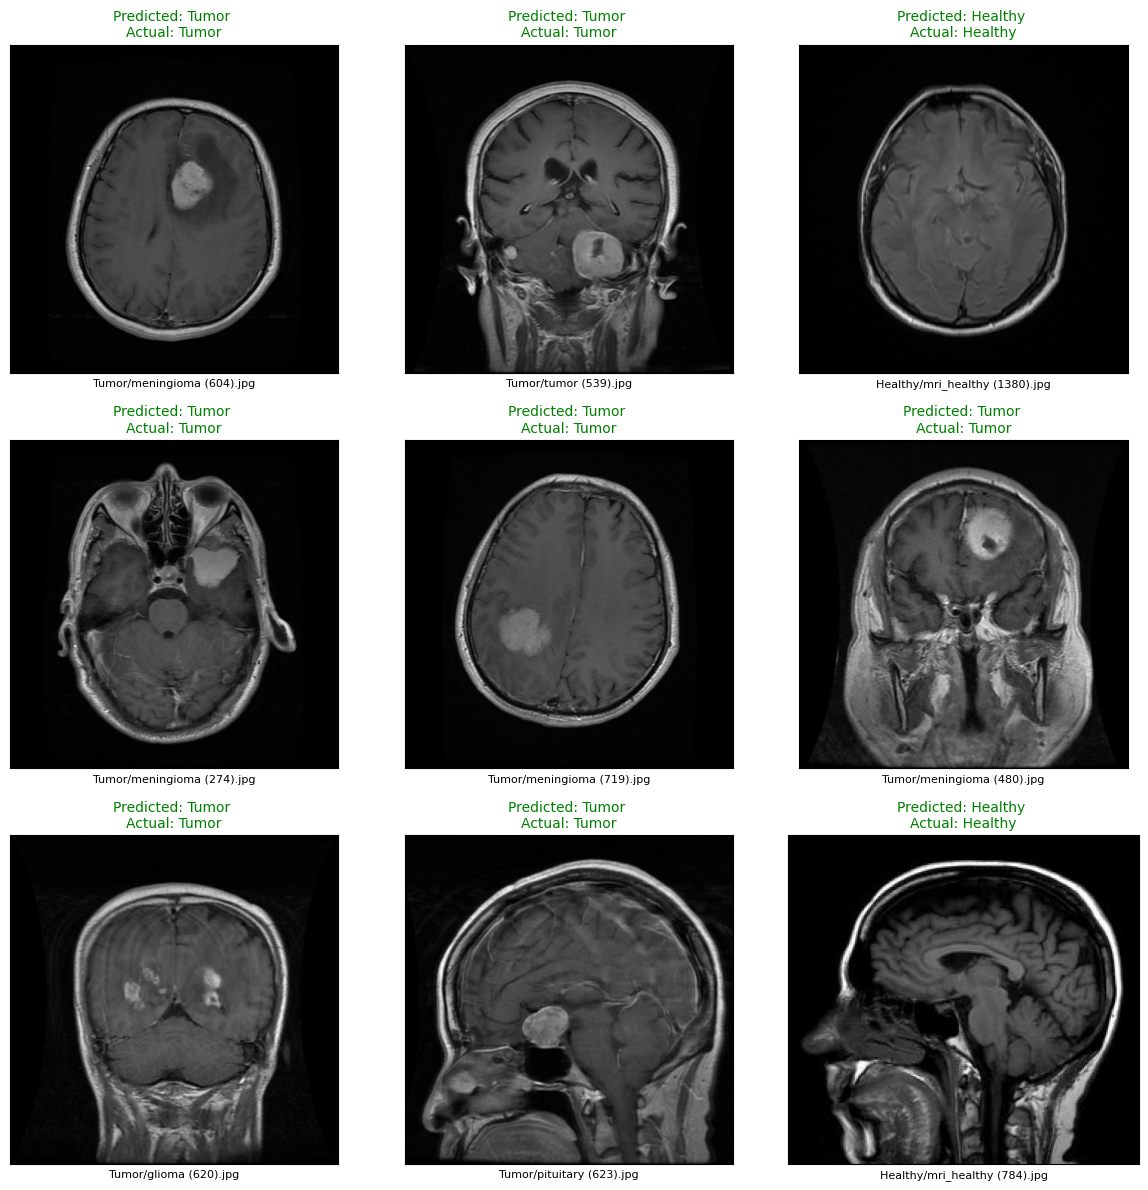

In [20]:
import random
from PIL import Image
from torchvision import transforms

# Set your image directory and batch size
image_dir = "./brain_tumor_data/Dataset/Brain Tumor MRI images"
batch_size = 9  # Grid layout: 4, 9, 16,

# Get all image file paths recursively
image_files = [os.path.join(root, file)
               for root, _, files in os.walk(image_dir)
               for file in files if file.lower().endswith((".jpg", ".png", ".jpeg"))]

# Randomly select a batch of images
selected_paths = random.sample(image_files, batch_size)

# Preprocessing transform (matching training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Class label mapping
class_names = {0: "Healthy", 1: "Tumor"}

# Load and preprocess images
images = []
original_images = []
true_labels = []
short_paths = []

for path in selected_paths:
    img = Image.open(path).convert("RGB")
    original_images.append(img)
    images.append(transform(img))

    # Ground-truth label from folder name
    if "healthy" in path.lower():
        true_labels.append("Healthy")
    elif "tumor" in path.lower():
        true_labels.append("Tumor")
    else:
        true_labels.append("Unknown")

    # Extract the last subfolder and file name
    short_path = os.path.join(os.path.basename(os.path.dirname(path)), os.path.basename(path))
    short_paths.append(short_path)

# Stack into a batch and move to device
input_batch = torch.stack(images).to(device)

# Run predictions
mri_model.eval()
with torch.no_grad():
    outputs = mri_model(input_batch)
    probs = torch.softmax(outputs, dim=1)
    confidences, predicted_classes = torch.max(probs, 1)

# Plot results in a grid
grid_size = int(batch_size ** 0.5)
plt.figure(figsize=(grid_size * 4, grid_size * 4))

for i in range(batch_size):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(original_images[i])
    pred_label = class_names[predicted_classes[i].item()]
    true_label = true_labels[i]
    # confidence = confidences[i].item()
    color = "green" if pred_label == true_label else "red"
    plt.title(f"Predicted: {pred_label} \nActual: {true_label}", color=color, fontsize=10)
    plt.xlabel(short_paths[i], fontsize=8)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()


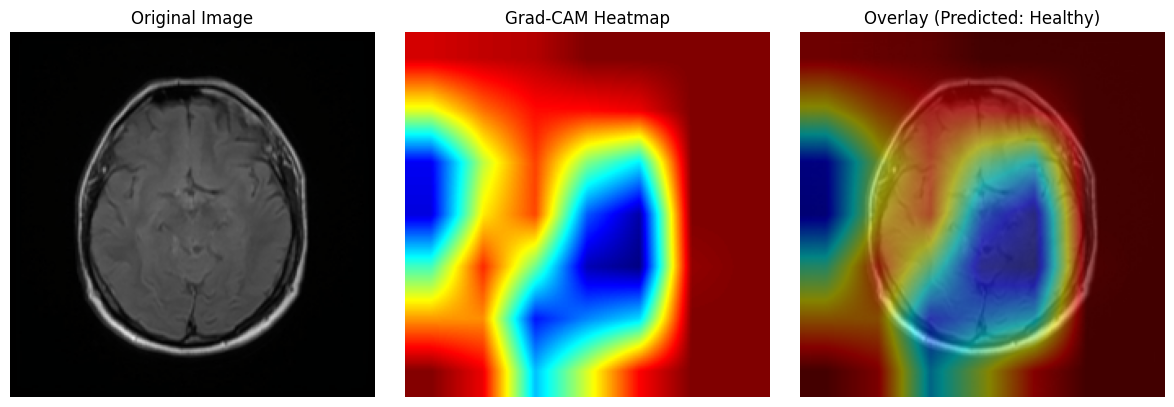

In [21]:
from torchvision.transforms.functional import to_pil_image

def generate_gradcam(model, input_tensor, target_class, target_layer):
    model.eval()

    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor)
    class_score = output[0, target_class]
    model.zero_grad()
    class_score.backward()

    # Get hooked data
    grad = gradients[0][0]         # [C, H, W]
    act = activations[0][0]        # [C, H, W]

    weights = torch.mean(grad, dim=(1, 2))  # [C]
    device = act.device  # Get current device (cpu or cuda)

    # Create CAM on the same device
    cam = torch.zeros(act.shape[1:], dtype=torch.float32, device=device)

    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.clamp(cam, min=0)
    cam -= cam.min()
    cam /= cam.max()
    cam = cam.detach().cpu().numpy()
    cam = cv2.resize(cam, (224, 224))
    cam = (cam * 255).astype(np.uint8)

    # Convert grayscale CAM to heatmap
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Clean up hooks
    forward_handle.remove()
    backward_handle.remove()

    return heatmap

# --- Apply Grad-CAM to one sample image from your batch ---
index = 2  # 🔁 Change to any index in your selected image batch

# Prepare original image
original_image = original_images[index]
input_tensor = input_batch[index].unsqueeze(0).to(device)  # Ensure it's on the correct device
pred_class = predicted_classes[index].item()

# Select the last Conv2D layer (adjust index as needed for your model)
target_layer = mri_model.layer_stack[-4]  # Example: Conv2D before AdaptiveAvgPool2d

# Generate Grad-CAM
heatmap = generate_gradcam(mri_model, input_tensor, pred_class, target_layer)

# Unnormalize the input image for visualization
unnorm = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)
unnorm_tensor = unnorm(input_tensor[0].cpu())
original_np = np.transpose(unnorm_tensor.numpy(), (1, 2, 0))
original_np = np.clip(original_np, 0, 1)

# Overlay heatmap on original image
overlay = heatmap + original_np
overlay = overlay / overlay.max()

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay (Predicted: {class_names[pred_class]})")
plt.axis('off')

plt.tight_layout()
plt.show()


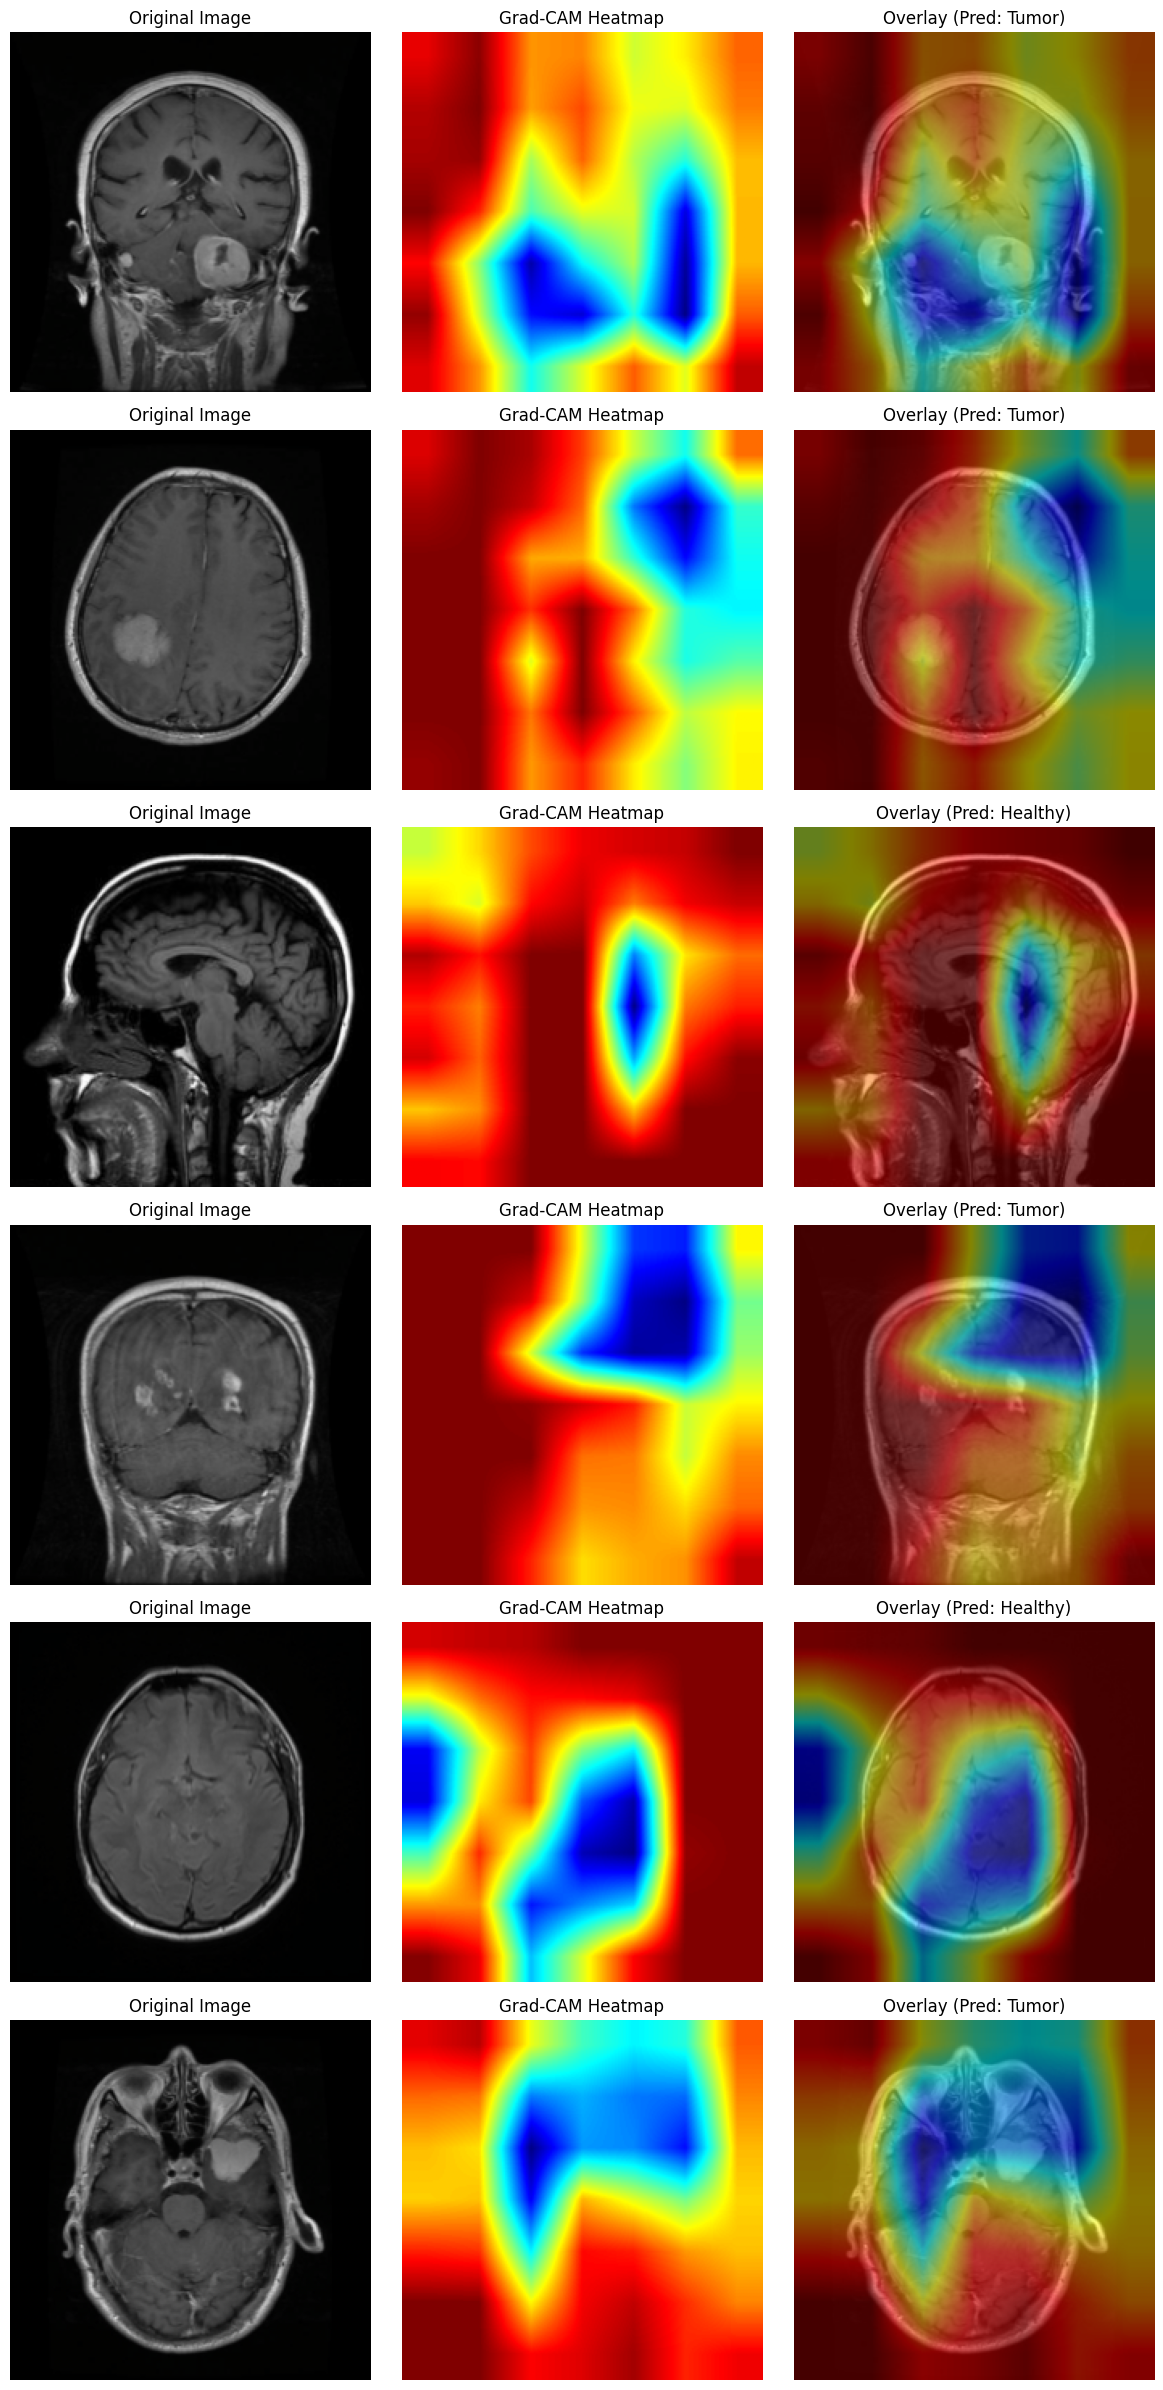

In [22]:

def generate_gradcam(model, input_tensor, target_class, target_layer):
    model.eval()

    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Forward and backward pass
    output = model(input_tensor)
    class_score = output[0, target_class]
    model.zero_grad()
    class_score.backward()

    # Get data
    grad = gradients[0][0]
    act = activations[0][0]
    weights = torch.mean(grad, dim=(1, 2))

    device = act.device
    cam = torch.zeros(act.shape[1:], dtype=torch.float32, device=device)
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.clamp(cam, min=0)
    cam -= cam.min()
    cam /= cam.max()
    cam = cam.detach().cpu().numpy()
    cam = cv2.resize(cam, (224, 224))
    cam = (cam * 255).astype(np.uint8)

    # Heatmap
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Clean up
    forward_handle.remove()
    backward_handle.remove()

    return heatmap

# --- Grad-CAM for random samples ---
num_samples = 6  # 🔁 Change to how many random Grad-CAMs you want

# Get random indices from the batch
indices = random.sample(range(len(input_batch)), num_samples)

# Plot Grad-CAM results
plt.figure(figsize=(12, 4 * num_samples))

for plot_idx, idx in enumerate(indices):
    original_image = original_images[idx]
    input_tensor = input_batch[idx].unsqueeze(0).to(device)
    pred_class = predicted_classes[idx].item()
    target_layer = mri_model.layer_stack[-4]  # Adjust as needed

    # Generate Grad-CAM
    heatmap = generate_gradcam(mri_model, input_tensor, pred_class, target_layer)

    # Unnormalize input image
    unnorm = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
        std=[1/s for s in [0.229, 0.224, 0.225]]
    )
    unnorm_tensor = unnorm(input_tensor[0].cpu())
    original_np = np.transpose(unnorm_tensor.numpy(), (1, 2, 0))
    original_np = np.clip(original_np, 0, 1)

    overlay = heatmap + original_np
    overlay = overlay / overlay.max()

    # Plot Original
    plt.subplot(num_samples, 3, plot_idx * 3 + 1)
    plt.imshow(original_np)
    plt.title("Original Image")
    plt.axis('off')

    # Plot Heatmap
    plt.subplot(num_samples, 3, plot_idx * 3 + 2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    # Plot Overlay
    plt.subplot(num_samples, 3, plot_idx * 3 + 3)
    plt.imshow(overlay)
    plt.title(f"Overlay (Pred: {class_names[pred_class]})")
    plt.axis('off')

plt.tight_layout()
plt.show()


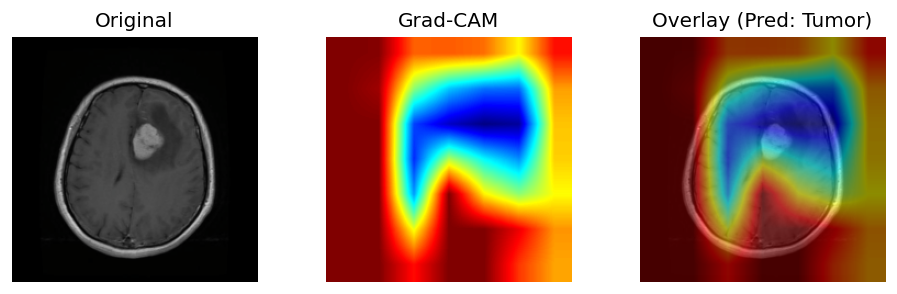

Saved Grad-CAM to /content/drive/MyDrive/Colab Notebooks/gradcam_outputs/gradcam_sample_1.png


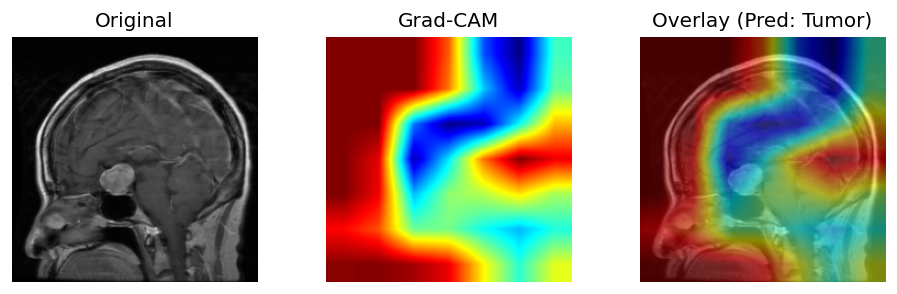

Saved Grad-CAM to /content/drive/MyDrive/Colab Notebooks/gradcam_outputs/gradcam_sample_2.png


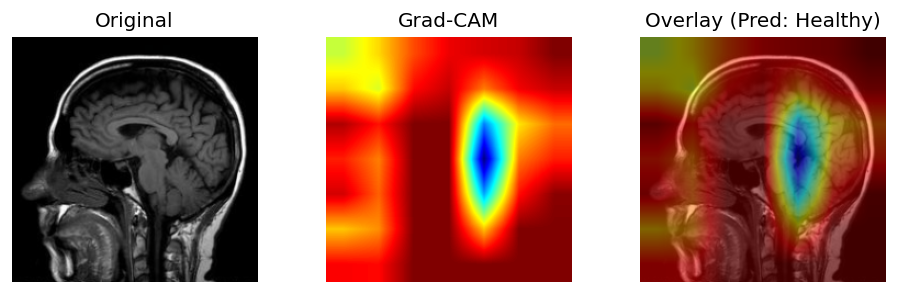

Saved Grad-CAM to /content/drive/MyDrive/Colab Notebooks/gradcam_outputs/gradcam_sample_3.png


In [23]:


# Grad-CAM generation function
def generate_gradcam(model, input_tensor, target_class, target_layer):
    model.eval()
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    output = model(input_tensor)
    class_score = output[0, target_class]
    model.zero_grad()
    class_score.backward()

    grad = gradients[0][0]
    act = activations[0][0]
    weights = torch.mean(grad, dim=(1, 2))

    device = act.device
    cam = torch.zeros(act.shape[1:], dtype=torch.float32, device=device)
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.clamp(cam, min=0)
    cam -= cam.min()
    cam /= cam.max()
    cam = cam.detach().cpu().numpy()
    cam = cv2.resize(cam, (224, 224))
    cam = (cam * 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    forward_handle.remove()
    backward_handle.remove()

    return heatmap

# Choose number of random samples from the batch
num_samples = 3
indices = random.sample(range(len(input_batch)), num_samples)

# Unnormalize transform
unnorm = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

# Optional: Directory to save outputs
output_dir = "/content/drive/MyDrive/Colab Notebooks/gradcam_outputs"
os.makedirs(output_dir, exist_ok=True)

# Display and optionally save results
for plot_idx, idx in enumerate(indices):
    original_image = original_images[idx]
    input_tensor = input_batch[idx].unsqueeze(0).to(device)
    pred_class = predicted_classes[idx].item()
    target_layer = mri_model.layer_stack[-4]  # adjust if needed

    heatmap = generate_gradcam(mri_model, input_tensor, pred_class, target_layer)

    # Unnormalize
    unnorm_tensor = unnorm(input_tensor[0].cpu())
    original_np = np.transpose(unnorm_tensor.numpy(), (1, 2, 0))
    original_np = np.clip(original_np, 0, 1)
    overlay = heatmap + original_np
    overlay = overlay / overlay.max()

    # Plot small clean figure (ideal for scrolling)
    fig, ax = plt.subplots(1, 3, figsize=(8, 2.5), dpi=120)
    ax[0].imshow(original_np)
    ax[0].set_title("Original")
    ax[0].axis('off')

    ax[1].imshow(heatmap)
    ax[1].set_title("Grad-CAM")
    ax[1].axis('off')

    ax[2].imshow(overlay)
    ax[2].set_title(f"Overlay (Pred: {class_names[pred_class]})")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Optional: Save the figure to disk
    save_path = os.path.join(output_dir, f"gradcam_sample_{plot_idx+1}.png")
    fig.savefig(save_path, bbox_inches='tight')
    print(f"Saved Grad-CAM to {save_path}")


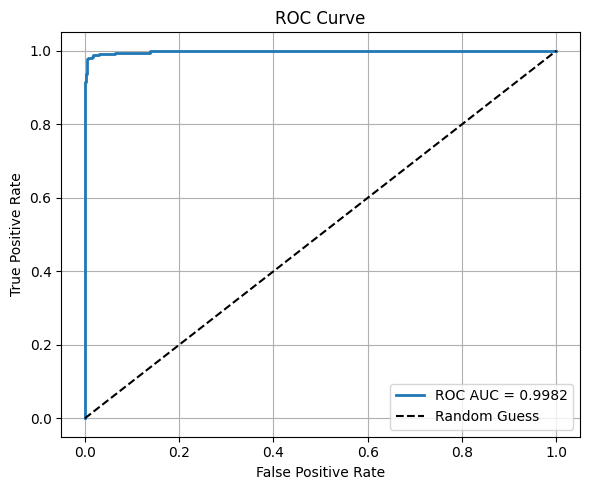

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve


# Collect true labels and predicted probabilities
mri_all_labels = []
mri_all_probs = []

mri_model.eval()
with torch.no_grad():
    for images, labels in MRI_test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = mri_model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Prob for class 1 (Tumor)

        mri_all_labels.extend(labels.cpu().numpy())
        mri_all_probs.extend(probs.cpu().numpy())

# Compute ROC-AUC and plot
fpr, tpr, thresholds = roc_curve(mri_all_labels, mri_all_probs)
roc_auc = roc_auc_score(mri_all_labels, mri_all_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
